In [1]:
%env MUJOCO_GL=egl

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".20"  #restrict JAX to 20% of available GPU RAM; useful for loading MyoSuite and UitB policies simultaneously

env: MUJOCO_GL=egl


In [2]:
import mujoco
from mujoco import mjx

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from brax import envs
# from brax.training.acme.running_statistics import normalize
# from brax.training.acme import running_statistics
# from brax.io import model
# from etils import epath
import functools

import myosuite
# from myosuite.envs.myo.myouser.utils import update_target_visuals
from myosuite.train.utils.train import train_or_load_checkpoint
from myosuite.train.utils.wrapper import _maybe_wrap_env_for_evaluation
from myosuite.envs.myo.myouser.evaluate import evaluate_policy
from myosuite.envs.myo.myouser.utils import render_traj
from myosuite.envs.myo.myouser.utils_steering import tunnel_from_nodes, distance_to_tunnel
import mediapy as media

import jax
import jax.numpy as jp

from mujoco_playground import wrapper, registry
from ml_collections import ConfigDict
import json

myo_path = os.path.dirname(os.path.dirname(myosuite.__file__))
os.chdir(myo_path)

MyoSuite:> Registering Myo Envs
MyoSuite:> Registering MyoUser Envs


In [ ]:
# # if module functions need to be reimported...

# import sys, importlib
# importlib.reload(sys.modules['myosuite.envs.myo.myouser.utils_steering'])
# from myosuite.envs.myo.myouser.utils_steering import tunnel_from_nodes, distance_to_tunnel


In [3]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Sat Aug 30 15:30:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.158.01             Driver Version: 570.158.01     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:01:00.0 Off |                  N/A |
| 30%   53C    P1            118W /  600W |   31755MiB /  32607MiB |     81%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ./logs/ --port 6006

In [7]:
# params[1]["params"]["hidden_3"]["kernel"].shape

Load Environment

In [4]:
# env_name = "MyoUserPointing"
# env_name = "MyoUserSteering"
env_name = "MyoUserMenuSteering"

print(f"Current backend: {jax.default_backend()}")

Current backend: gpu


In [6]:
# ## LOADING DEPRECATED CHECKPOINTS (NOT SAFE!!!):

# checkpoint_path = "logs/MyoUserSteering-20250816-020256-Testv002hNoCollision80and50fixedoffset0.5Collision/checkpoints"

# # env_cfg = registry.get_default_config(env_name)
# with open(os.path.join(checkpoint_path, "config.json"), "r") as f:
#     env_cfg = ConfigDict(json.load(f))

# with env_cfg.unlocked():
#     env_cfg.vision.enabled = False
    
#     env_cfg.task_config.min_width: float = 0.3
#     env_cfg.task_config.min_height: float = 0.1
#     env_cfg.task_config.bottom: float = -0.3
#     env_cfg.task_config.top: float = 0.3
#     env_cfg.task_config.left: float = 0.3
#     env_cfg.task_config.right: float = -0.3

# _env = registry.load(env_name, config=env_cfg)
# rng_init = jax.random.PRNGKey(0)
# init_state = _env.reset(rng_init)

In [5]:
## VARIANT 1: load env, and load policy params from latest run 
# Note: load_checkpoint always loads latest checkpoint from this run

# checkpoint_path = "logs/MyoUserPointing-20250718-200508/checkpoints"
# checkpoint_path = "logs/MyoUserPointing-20250721-221417/checkpoints"
# checkpoint_path = "logs/MyoUserPointing-20250723-150450-MyoUserBase/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250726-224307-FixedRewardv2/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250815-230528-Testv002hNoCollision80and50fixedoffset0.5/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250815-232641-Testv002hNoCollision80and50fixedoffset0.5Collision/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250816-020256-Testv002hNoCollision80and50fixedoffset0.5Collision/checkpoints"
# checkpoint_path = get_latest_run_path("logs/")
# checkpoint_path = "logs/MyoUserSteering-20250826-225527/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250827-100031/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250828-002547-reducedCollisions_epsReset_minorImprovs/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250828-170017/checkpoints"
# checkpoint_path = "logs/MyoUserSteering-20250829-001249-dwell0and1/checkpoints/75018240"
checkpoint_path = "logs/MyoUserMenuSteering-20250830-143838/checkpoints"

# env_cfg = registry.get_default_config(env_name)
_cfg_path = os.path.join(checkpoint_path, "config.json") if checkpoint_path.rstrip("/").endswith("checkpoints") else os.path.join(checkpoint_path, "../config.json") 
with open(_cfg_path, "r") as f:
    env_cfg = ConfigDict(json.load(f))

env, make_inference_fn, params = train_or_load_checkpoint(env_name, env_cfg, eval_mode=True, checkpoint_path=checkpoint_path)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

env, n_randomizations = _maybe_wrap_env_for_evaluation(eval_env=env, seed=env_cfg.run.eval_seed)

jit_reset = jax.jit(env.eval_reset)
jit_step = jax.jit(env.step)

Restoring from: /scratch/fjf33/myouser/logs/MyoUserMenuSteering-20250830-143838/checkpoints/25006080
Checkpoint path: /scratch/fjf33/myouser/logs/MyoUserMenuSteering-20250830-143838/checkpoints


No vision, so adding ['screen_pos', 'completed_phase_0_arr', 'target', 'percentage_of_remaining_path', 'distance_to_tunnel_bounds'] to obs_keys
Obs keys: ['qpos', 'qvel', 'qacc', 'fingertip', 'act', 'screen_pos', 'completed_phase_0_arr', 'target', 'percentage_of_remaining_path', 'distance_to_tunnel_bounds']
No vision, so adding ['screen_pos', 'completed_phase_0_arr', 'target', 'percentage_of_remaining_path', 'distance_to_tunnel_bounds'] to obs_keys
Obs keys: ['qpos', 'qvel', 'qacc', 'fingertip', 'act', 'screen_pos', 'completed_phase_0_arr', 'target', 'percentage_of_remaining_path', 'distance_to_tunnel_bounds']
num_training_interruptions: 3


In [7]:
## Replay stored video
rollout_stored = np.load(os.path.join(checkpoint_path, "../traj.pickle"), allow_pickle=True)
render_traj(rollout_stored, eval_env=env)  #, camera=None)

# frames = env.render(rollout_stored) #, camera="fixed-eye") #, modify_scene_fns=mod_fns)
# rewards = [s.reward for s in rollout_stored]
# print(sum(rewards))
# media.show_video(frames, fps=1.0 / env.dt)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/MyoUserMenuSteering-20250830-024130-dwell0and1_relaxed1/checkpoints/../traj.pickle'

In [ ]:
## VARIANT 2: load env with default config, without policy 

from myosuite.envs.myo.myouser.hydra_cli import load_config_interactive
overrides=["env=steering"]  #, "env.task_config.reach_settings.target_radius_range.fingertip=[0.01,0.15]"]
config_dict=load_config_interactive(overrides)
env = registry.load("MyoUserSteering", config=config_dict.env)

env, n_randomizations = _maybe_wrap_env_for_evaluation(eval_env=env, seed=config_dict.run.eval_seed)

jit_reset = jax.jit(env.eval_reset)
jit_step = jax.jit(env.step)

No vision, so adding ['screen_pos', 'start_line', 'end_line', 'top_line', 'bottom_line', 'completed_phase_0_arr', 'target'] to obs_keys
Obs keys: ['qpos', 'qvel', 'qacc', 'fingertip', 'act', 'screen_pos', 'start_line', 'end_line', 'top_line', 'bottom_line', 'completed_phase_0_arr', 'target']


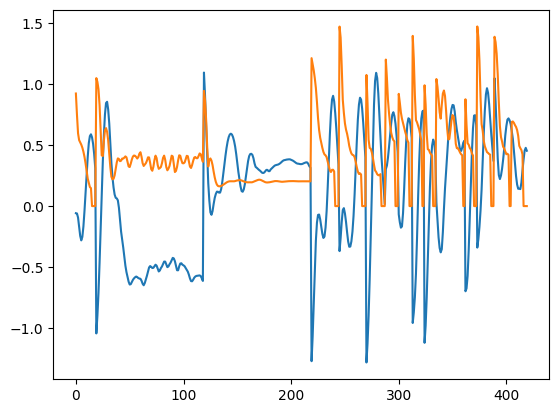

In [27]:
import matplotlib.pyplot as plt

plt.plot([r.data.qpos[env.mj_model.joint(("pro_sup")).id] for r in rollout_stored])
plt.plot([r.metrics["distance_phase_0"] for r in rollout_stored])

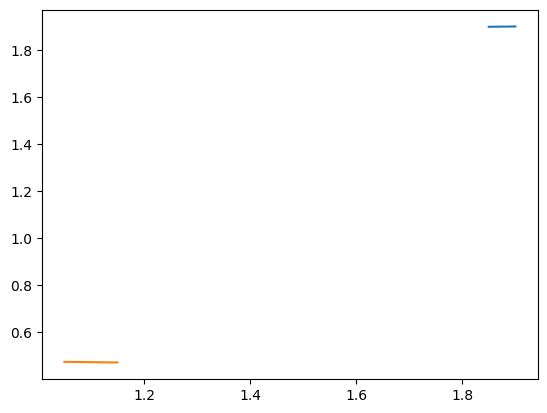

In [47]:
_jnt_id = env.mj_model.joint(("elv_angle")).id

plt.plot([r.data.time for r in rollout_stored[55:57]], [r.data.qpos[_jnt_id] for r in rollout_stored[55:57]])
plt.plot([r.data.time for r in rollout_stored_CP[55:57]], [r.data.qpos[_jnt_id] for r in rollout_stored_CP[55:57]])
# plt.plot([r.data.time for r in rollout_stored_CP[:100]], [r.metrics["distance_phase_1"] for r in rollout_stored_CP[:100]], linestyle="--")

In [6]:
# ## VARIANT 2: load params from pickle file

# env_cfg = registry.get_default_config(env_name)
# env = registry.load(env_name, config=env_cfg)

# #param_path = os.path.join(os.path.dirname(checkpoint_path), 'playground_params.pickle')
# param_path = "/scratch/fjf33/myosuite_ankit/myosuite-mjx-policies/myouserbase_params"

# normalize_observations = True
# ppo_network = custom_network_factory(
#     obs_shape=get_observation_size(),  # Example observation shape
#     action_size=26,  # Example action size,
#     policy_hidden_layer_sizes=(256, 256),  #(50, 50, 50),
#     value_hidden_layer_sizes=(256, 256),  #(50, 50, 50),
#     preprocess_observations_fn=running_statistics.normalize if normalize_observations else lambda x, y: x  # Identity function for preprocessing
# )

# params = model.load_params(param_path)
# def deterministic_policy(input_data):
#     logits = ppo_network.policy_network.apply(*params[:2], input_data)
#     brax_result = ppo_network.parametric_action_distribution.mode(logits)
#     return brax_result
# params

### Internal Testing

In [ ]:
from brax.training import acting

eval_env = wrapper.wrap_for_brax_training(env, episode_length=200)

rng = jax.random.PRNGKey(123)
rng, eval_key = jax.random.split(rng)

# key = jax.random.PRNGKey(123)
# global_key, local_key = jax.random.split(key)
# del key
# local_key = jax.random.fold_in(local_key, jax.process_index())
# local_key, key_env, eval_key = jax.random.split(local_key, 3)

evaluator = acting.Evaluator(
    eval_env,
    functools.partial(make_inference_fn, deterministic=True),
    num_eval_envs=1,
    episode_length=200,
    action_repeat=1,
    key=eval_key,
)

metrics = evaluator.run_evaluation(params, {})

In [9]:
evaluator._key, unroll_key = jax.random.split(evaluator._key)
eval_state = evaluator._generate_eval_unroll(params, unroll_key)
eval_state.info["eval_metrics"].episode_metrics

{'reach_dist': Array([0.02351627], dtype=float32),
 'reward': Array([6.330341], dtype=float32),
 'success_rate': Array([1.], dtype=float32),
 'target_area_dynamic_width_scale': Array([0.], dtype=float32)}

In [55]:
from brax.training.acting import generate_unroll
_eval_env = envs.training.EvalWrapper(eval_env)
def _generate_unroll(params, key, num_eval_envs=1):
    reset_keys = jax.random.split(key, num_eval_envs)
    eval_first_state = _eval_env.reset(reset_keys)
    return generate_unroll(
    _eval_env, eval_first_state,
    make_inference_fn(params, deterministic=True),
    key=key,
    unroll_length=200)
generate_unroll_jit = jax.jit(_generate_unroll)

In [56]:
# _eval_env = envs.training.EvalWrapper(eval_env)
evaluator._key, unroll_key = jax.random.split(evaluator._key)
# reset_keys = jax.random.split(unroll_key, 1)
# eval_first_state = _eval_env.reset(reset_keys)
# eval_final_state, eval_data = generate_unroll(
#     _eval_env, eval_first_state,
#     make_inference_fn(params, deterministic=True),
#     key=unroll_key,
#     unroll_length=200)
eval_final_state, eval_data = generate_unroll_jit(
    params, key=unroll_key)

In [57]:
eval_data.reward.sum(), eval_final_state.info["eval_metrics"].episode_metrics

(Array(-10.9054, dtype=float32),
 {'reach_dist': Array([0.02216392], dtype=float32),
  'reward': Array([6.478419], dtype=float32),
  'success_rate': Array([1.], dtype=float32),
  'target_area_dynamic_width_scale': Array([0.], dtype=float32)})

### Visualize Rollouts

In [15]:
# rng_init = jax.random.PRNGKey(0)
# init_state = env.reset(rng_init)

# init_state.data.contact.geom1, init_state.data.contact.geom2
# [(_id, env.mj_model.geom(_id).name) for _id in init_state.data.contact.geom1]

/tmp/ipykernel_25786/2684542085.py:4: DeprecationWarning: Accessing `contact` directly from `Data` is deprecated. Access it via `data._impl.contact` instead.
  init_state.data.contact.geom1, init_state.data.contact.geom2
/tmp/ipykernel_25786/2684542085.py:5: DeprecationWarning: Accessing `contact` directly from `Data` is deprecated. Access it via `data._impl.contact` instead.
  [(_id, env.mj_model.geom(_id).name) for _id in init_state.data.contact.geom1]


[(Array(37, dtype=int32), 'fingertip_contact')]

In [120]:
##TODO: normalise with respect to arc length?
# _theta = 1
# (_interp_fct_left(_theta - _delta) - _interp_fct_left(_theta))/_delta

array([-0., -4.])

Test implementation of tunnel creation as standalone

In [ ]:
# import jax._src.scipy.optimize as jax_optimize
jax._src.scipy.optimize.bfgs.minimize_bfgs

<function jax._src.scipy.optimize.bfgs.minimize_bfgs(fun: 'Callable', x0: 'jax.Array', maxiter: 'int | None' = None, norm=inf, gtol: 'float' = 1e-05, line_search_maxiter: 'int' = 10) -> '_BFGSResults'>

In [38]:
jax._src.scipy.optimize.bfgs.minimize_bfgs(x0=jp.array([2/3]), fun=lambda theta: jp.linalg.norm(_interp_fct_left(jp.array(theta)) - jp.array(test_point))).x_k

Array([0.68521273], dtype=float32)

In [92]:
import jaxopt


def distance_to_tunnel_TEST(test_point, _interp_fct_left=None, _interp_fct_right=None, theta_init=2/3):
    """
    Estimates(!) whether a given point is inside tunnel or not, and returns the signed distance (negative distance: outside tunnel).
    NOTES:
    - To avoid starting the optimization at a discontinuity, theta_init should NOT be set to 1/(len(nodes)-1), 2/(len(nodes)-1), ..., (len(nodes)-2)/(len(nodes)-1).
    - To perform a warm start, the theta identified at the last step can be passed as theta_init.
    """
    buffer_size = 101
    buffer_theta = jp.linspace(0, 1, buffer_size)
    buffer_nodes_left = _interp_fct_left(buffer_theta)
    buffer_nodes_right = _interp_fct_right(buffer_theta)

    # find nearest parametrization value of both boundary curves
    # # theta_closest = scipy.optimize.minimize(lambda theta: jp.linalg.norm(_interp_fct(theta) - test_point), 0.7, bounds=[(0, 1)], method="Nelder-Mead", options={"maxiter": 100000}).x.item()
    # theta_closest_left = scipy.optimize.shgo(lambda theta: jp.linalg.norm(_interp_fct_left(theta) - test_point), bounds=[(0, 1)]).x.item()
    # theta_closest_right = scipy.optimize.shgo(lambda theta: jp.linalg.norm(_interp_fct_right(theta) - test_point), bounds=[(0, 1)]).x.item()
    # theta_closest_left = jaxopt.GradientDescent(fun=lambda theta: jp.linalg.norm(_interp_fct_left(jp.array(theta)) - jp.array(test_point))).run(jp.array(theta_init)).params
    # theta_closest_right = jaxopt.GradientDescent(fun=lambda theta: jp.linalg.norm(_interp_fct_right(jp.array(theta)) - jp.array(test_point))).run(jp.array(theta_init)).params
    # theta_closest_left = jaxopt.ProjectedGradient(fun=lambda theta: jp.linalg.norm(_interp_fct_left(jp.array(theta)) - jp.array(test_point)), projection=jaxopt.projection.projection_box).run(jp.array(theta_init), hyperparams_proj=(0, 1)).params
    # theta_closest_right = jaxopt.ProjectedGradient(fun=lambda theta: jp.linalg.norm(_interp_fct_right(jp.array(theta)) - jp.array(test_point)), projection=jaxopt.projection.projection_box).run(jp.array(theta_init), hyperparams_proj=(0, 1)).params
    # theta_closest_left = jax._src.scipy.optimize.bfgs.minimize_bfgs(x0=jp.array([theta_init]), fun=lambda theta: jp.linalg.norm(_interp_fct_left(jp.array(theta)) - jp.array(test_point))).x_k.item()
    # theta_closest_right = jax._src.scipy.optimize.bfgs.minimize_bfgs(x0=jp.array([theta_init]), fun=lambda theta: jp.linalg.norm(_interp_fct_right(jp.array(theta)) - jp.array(test_point))).x_k.item()
    buffer_id_closest_left = jp.argmin(jp.linalg.norm(buffer_nodes_left - jp.array(test_point), axis=1))
    buffer_id_closest_right = jp.argmin(jp.linalg.norm(buffer_nodes_right - jp.array(test_point), axis=1))
    theta_closest_left, theta_closest_right = buffer_theta[buffer_id_closest_left], buffer_theta[buffer_id_closest_right]

    # left_bound_closest, right_bound_closest = _interp_fct_left(theta_closest_left), _interp_fct_right(theta_closest_right)
    left_bound_closest, right_bound_closest = buffer_nodes_left[buffer_id_closest_left], buffer_nodes_right[buffer_id_closest_right]
    left_vector = left_bound_closest - test_point
    right_vector = right_bound_closest - test_point
    inside_tunnel = jp.dot(left_bound_closest - test_point, right_bound_closest - test_point) < 0
    tunnel_distance = jp.minimum(jp.linalg.norm(left_vector), jp.linalg.norm(right_vector)) * (-1)**(~inside_tunnel)
    return tunnel_distance, theta_closest_left, theta_closest_right

In [69]:
buffer_size = 101
buffer_theta = np.linspace(0, 1, buffer_size)
buffer_nodes_left = _interp_fct_left(buffer_theta)
buffer_nodes_right = _interp_fct_right(buffer_theta)

(Array(-0.01096486, dtype=float32),
 Array(0.69, dtype=float32),
 Array(0.62, dtype=float32),
 Array([ 0.24000001, -0.25322723], dtype=float32),
 Array([ 0.16      , -0.24550241], dtype=float32))

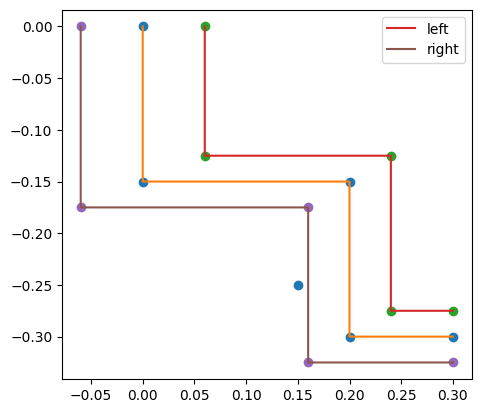

In [9]:
# import numpy as np
# import scipy
import interpax
import matplotlib.pyplot as plt

# nodes = np.array([[0., 1.], [1., 1.], [1, -3.], [3, -3], [3, -5], [-4, -5], [-4, -2]])
nodes = jp.array([[0., 0.], [0., -0.15], [0.2, -0.15], [0.2, -0.3], [0.3, -0.3]])
tunnel_size = None #0.2
width_height_constraints = [("width", 0.12), ("height", 0.05), ("width", 0.08), ("height", 0.05), ("height", 0.05)]
spline_ord = 1  #2

# nodes = np.array([[0., 1.], [2., 1.], [5., 1.]])
# tunnel_size = [1, 2, 1]
# width_height_constraints = None
# spline_ord = 2  #1

theta_interp = jp.linspace(0, 1, 100)  #points at which to evaluate bounds; only useful if spline_order > 1, otherwise set to theta


theta = jp.linspace(0, 1, len(nodes))
# _interp_fct = scipy.interpolate.make_interp_spline(np.array(theta), np.array(nodes), k=spline_ord)
_interp_fct = interpax.PchipInterpolator(theta, nodes, check=False)
xy_interp = _interp_fct(theta_interp)
plt.plot(nodes[:, 0], nodes[:, 1], 'o')
plt.plot(xy_interp[:, 0], xy_interp[:, 1], '-')

nodes_left, nodes_right = tunnel_from_nodes(nodes, tunnel_size=tunnel_size, width_height_constraints=width_height_constraints)

# _interp_fct_left = scipy.interpolate.make_interp_spline(np.array(theta), np.array(nodes_left), k=spline_ord)
_interp_fct_left = interpax.PchipInterpolator(theta, nodes_left, check=False)
xy_interp_left = _interp_fct_left(theta_interp)
plt.plot(nodes_left[:, 0], nodes_left[:, 1], 'o')
plt.plot(xy_interp_left[:, 0], xy_interp_left[:, 1], '-', label="left")

# _interp_fct_right = scipy.interpolate.make_interp_spline(np.array(theta), np.array(nodes_right), k=spline_ord)
_interp_fct_right = interpax.PchipInterpolator(theta, nodes_right, check=False)
xy_interp_right = _interp_fct_right(theta_interp)
plt.plot(nodes_right[:, 0], nodes_right[:, 1], 'o')
plt.plot(xy_interp_right[:, 0], xy_interp_right[:, 1], '-', label="right")

plt.legend()
plt.gca().set_aspect('equal')


## testing accuracy of inside_tunnel detection
test_point = jp.array([0.15, -0.25])
plt.scatter(*test_point)
distance_to_tunnel(test_point, _interp_fct_left, _interp_fct_right)

In [9]:
# np.linalg.norm(nodes_right - nodes_left, axis=1, ord=2)
np.linalg.norm(_interp_fct_right(1) - _interp_fct_left(1), ord=2)  #axis=1)

np.float32(0.050000012)

In [ ]:
# def get_custom_tunnel_horizontal(rng: jax.Array, data: mjx.Data) -> dict[str, jax.Array]:
#     bottom_line, top_line, left_line, right_line = env.get_custom_tunnel_centers(rng)
#     width_midway = (left_line + right_line) / 2
#     height_midway = (top_line + bottom_line) / 2
#     relevant_positions = env.get_relevant_positions(data)
#     tunnel_positions = {}
#     tunnel_positions['bottom_line'] = relevant_positions['screen_pos'] + jp.array([0., width_midway, bottom_line])
#     tunnel_positions['top_line'] = relevant_positions['screen_pos'] + jp.array([0., width_midway, top_line])
#     tunnel_positions['start_line'] = relevant_positions['screen_pos'] + jp.array([0., left_line, height_midway])
#     tunnel_positions['end_line'] = relevant_positions['screen_pos'] + jp.array([0., right_line, height_midway])
#     tunnel_positions['screen_pos'] = relevant_positions['screen_pos']
#     #jax.debug.print("width_midway: {}, height_midway: {}", width_midway, height_midway)
#     return tunnel_positions

# def get_custom_tunnel_vertical(rng: jax.Array, data: mjx.Data) -> dict[str, jax.Array]:
#     left_line, right_line, top_line, bottom_line = env.get_custom_tunnel_centers(rng)
#     width_midway = (left_line + right_line) / 2
#     height_midway = (top_line + bottom_line) / 2
#     relevant_positions = env.get_relevant_positions(data)
#     tunnel_positions = {}
#     tunnel_positions['bottom_line'] = relevant_positions['screen_pos'] + jp.array([0., width_midway, bottom_line])
#     tunnel_positions['top_line'] = relevant_positions['screen_pos'] + jp.array([0., width_midway, top_line])
#     tunnel_positions['start_line'] = relevant_positions['screen_pos'] + jp.array([0., left_line, height_midway])
#     tunnel_positions['end_line'] = relevant_positions['screen_pos'] + jp.array([0., right_line, height_midway])
#     tunnel_positions['screen_pos'] = relevant_positions['screen_pos']
#     #jax.debug.print("width_midway: {}, height_midway: {}", width_midway, height_midway)
#     return tunnel_positions

# def get_custom_tunnel(rng: jax.Array, data: mjx.Data, spline_ord: int = 1) -> dict[str, jax.Array]:
#     ## TODO: move to config
#     min_width, max_width = 0.05, 0.1
#     min_height, max_height = 0.03, 0.08

#     # Sample tunnel size
#     rng1, rng2 = jax.random.split(rng, 2)
#     rng2, rng_width = jax.random.split(rng2, 2)
#     width = min_width + jax.random.uniform(rng_width) * (2/3)*(max_width - min_width)  #default: 0.08
#     rng2, rng_height = jax.random.split(rng2, 2)
#     height = min_height + jax.random.uniform(rng_height) * (2/3)*(max_height - min_height)  #default: 0.05

#     screen_size = env.mj_model.site(env.screen_id).size[1:]
#     screen_pos_center = data.site_xpos[env.screen_id][1:]
#     screen_pos_topleft = screen_pos_center + 0.5*screen_size  #top-left corner of screen is used as anchor [0, 0] in nodes_rel below
#     screen_margin = np.array([0.05, 0.05])
#     screen_size_without_margin = screen_size - screen_margin

#     nodes_rel = np.array([[0., 0.], [0., -0.15], [0.2, -0.15], [0.2, -0.3], [0.3, -0.3]])  #nodes_rel are defined in relative coordinates (x, y), with x-axis to the right and y-axis to the top; [0, 0] should correspond to starting point at the top left, so most top-left tunnel boundary point will be [-1.5*width, 0]
#     tunnel_size = None #not required, since widths and heights are specified for each node individually using the 'width_height_constraints' arg
#     width_height_constraints = [("width", 1.5*width), ("height", height), ("width", width), ("height", height), ("height", height)]
#     total_size = np.linalg.norm(nodes_rel, axis=0, ord=np.inf) + 0.5 * np.array([1.5*width, height])

#     # Sample start pos
#     remaining_size = screen_size_without_margin - total_size
#     rng1, rng_width_offset = jax.random.split(rng1, 2)
#     start_width_offset = jax.random.uniform(rng_width_offset) * remaining_size[0]
#     rng1, rng_height_offset = jax.random.split(rng1, 2)
#     start_height_offset = jax.random.uniform(rng_height_offset) * remaining_size[1]
#     start_pos = screen_pos_topleft - 0.5 * np.array([1.5*width, height]) - np.array([start_width_offset, start_height_offset])
    
#     nodes = start_pos + np.array([-1., 1.]) * nodes_rel  #map from relative node coordinates (x, y) to MuJoCo coordinates (y, z) using (z <- y, y <- (-x))
#     nodes_left, nodes_right = tunnel_from_nodes(nodes, tunnel_size=tunnel_size, width_height_constraints=width_height_constraints)

#     theta = np.linspace(0, 1, len(nodes))
#     _interp_fct_left = scipy.interpolate.make_interp_spline(theta, nodes_left, k=spline_ord)
#     _interp_fct_right = scipy.interpolate.make_interp_spline(theta, nodes_right, k=spline_ord)

#     return nodes, _interp_fct_left, _interp_fct_right

In [10]:
# Compute path length
np.sum(np.linalg.norm(nodes[1:] - nodes[:-1], axis=1))

np.float32(0.6)

Test tunnels as created by environment

In [10]:
rng_init = jax.random.PRNGKey(0)
init_state = env.reset(rng_init)

TypeError: 'jaxlib.xla_extension.ArrayImpl' object is not callable

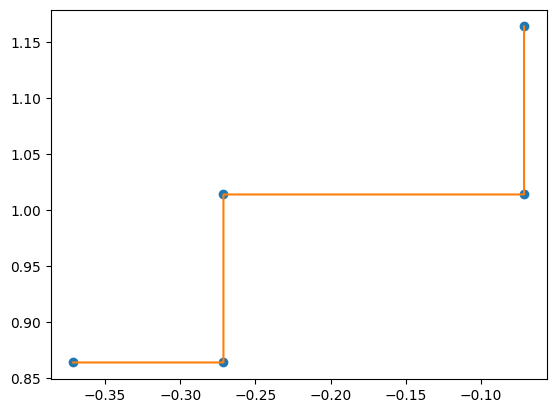

In [11]:
tunnel_info = env.get_custom_tunnel(rng_init, init_state.data)
nodes, _interp_fct_left, _interp_fct_right = tunnel_info["tunnel_nodes"], tunnel_info["tunnel_boundary_left"], tunnel_info["tunnel_boundary_right"]

theta_interp = np.linspace(0, 1, 100)  #points at which to evaluate bounds; only useful if spline_order > 1, otherwise set to theta
spline_ord = 1

theta = np.linspace(0, 1, len(nodes))
_interp_fct = interpax.PchipInterpolator(theta, nodes, check=False)# , k=spline_ord)
xy_interp = _interp_fct(theta_interp)
plt.plot(nodes[:, 0], nodes[:, 1], 'o')
plt.plot(xy_interp[:, 0], xy_interp[:, 1], '-')

xy_interp_left = _interp_fct_left(theta_interp)
# plt.plot(nodes_left[:, 0], nodes_left[:, 1], 'o')
plt.plot(xy_interp_left[:, 0], xy_interp_left[:, 1], '-', label="left")

xy_interp_right = _interp_fct_right(theta_interp)
# plt.plot(nodes_right[:, 0], nodes_right[:, 1], 'o')
plt.plot(xy_interp_right[:, 0], xy_interp_right[:, 1], '-', label="right")

plt.legend()
plt.gca().set_aspect('equal')
plt.gca().invert_xaxis()


## testing accuracy of inside_tunnel detection
test_point = nodes[-1] + np.array([0.02, 0])  #np.array([-0.35, 0.95])
plt.scatter(*test_point, color="black")
distance_to_tunnel(test_point, _interp_fct_left, _interp_fct_right, theta_init=0.8)

In [1208]:
init_state.data.site_xpos[env.screen_id]
# env.mj_model.site(env.screen_id).size[1:]

Array([ 0.532445, -0.27    ,  0.993   ], dtype=float32)

KeyError: 'screen_pos'

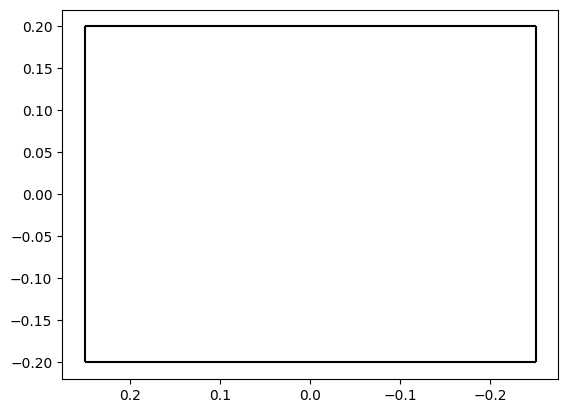

In [22]:
rng = jax.random.PRNGKey(1)


plt.gca().invert_xaxis()
plt.vlines([-0.25, 0.25], -0.2, 0.2, color="black")
plt.hlines([-0.2, 0.2], -0.25, 0.25, color="black")

for _ in range(1):
    ## HORIZONTAL PIECE
    rng, rng2 = jax.random.split(rng)
    _info_test = env.get_custom_tunnel(rng2, init_state.data)
    screen_pos = _info_test["screen_pos"] + jp.array([0.01, 0., 0.])  #need to re-introduce site pos offset from xml file that was ignored in get_custom_tunnel() to ensure that task visuals properly appear in front of the screen 
    screen_y = screen_pos[1]
    screen_z = screen_pos[2]
    top_line = _info_test["top_line"]
    bottom_line = _info_test["bottom_line"]
    start_line = _info_test["start_line"]
    end_line = _info_test["end_line"]
    bottom_z = bottom_line[2] - screen_z
    top_z = top_line[2] - screen_z
    left_y = start_line[1] - screen_y
    right_y = end_line[1] - screen_y
    width_midway = (left_y + right_y) / 2
    height_midway = (top_z + bottom_z) / 2
    height = top_z - bottom_z
    width = left_y - right_y
    plt.vlines([left_y, right_y], height_midway-height/2, height_midway+height/2, color=["green", "red"])
    plt.hlines([top_z, bottom_z], width_midway-width/2, width_midway+width/2, color="black")

    ## VERTICAL PIECE
    rng, rng2 = jax.random.split(rng)
    _info_test = env.get_custom_tunnel_vertical(rng2, init_state.data)
    screen_pos = _info_test["screen_pos"] + jp.array([0.01, 0., 0.])  #need to re-introduce site pos offset from xml file that was ignored in get_custom_tunnel() to ensure that task visuals properly appear in front of the screen 
    screen_y = screen_pos[1]
    screen_z = screen_pos[2]
    top_line = _info_test["top_line"]
    bottom_line = _info_test["bottom_line"]
    start_line = _info_test["start_line"]
    end_line = _info_test["end_line"]
    bottom_z = bottom_line[2] - screen_z
    top_z = top_line[2] - screen_z
    left_y = start_line[1] - screen_y
    right_y = end_line[1] - screen_y
    width_midway = (left_y + right_y) / 2
    # width_midway = right_y + width/2
    height_midway = (top_z + bottom_z) / 2
    height = top_z - bottom_z
    width = left_y - right_y
    plt.hlines([top_z, bottom_z], width_midway-width/2, width_midway+width/2, color=["green", "red"])
    plt.vlines([left_y, right_y], height_midway-height/2, height_midway+height/2, color="black")

# mj_model.site('bottom_line').pos[1:] = jp.array([width_midway, bottom_z])
# mj_model.site('bottom_line').size[1] = width / 2

# mj_model.site('top_line').pos[1:] = jp.array([width_midway, top_z])
# mj_model.site('top_line').size[1] = width / 2

# mj_model.site('start_line').pos[1:] = jp.array([left_y, height_midway])
# mj_model.site('start_line').size[2] = height / 2

# mj_model.site('end_line').pos[1:] = jp.array([right_y, height_midway])
# mj_model.site('end_line').size[2] = height / 2

In [23]:
[env.mj_model.geom(i).group for i in range(env.mj_model.ngeom)]

[array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], 

In [7]:
eval_key = jax.random.PRNGKey(123)
eval_key, reset_keys = jax.random.split(eval_key)
state0 = jit_reset(reset_keys, eval_id=jp.arange(24, dtype=jp.int32))  #, **reset_info_kwargs)
state = jit_step(state0, jp.zeros((24, env.mj_model.na)))
for _ in range(0):
    state = jit_step(state, jp.zeros((24, env.mj_model.na)))

BEFORE NOISE: Traced<ShapedArray(float32[26])>with<BatchTrace> with
  val = Traced<ShapedArray(float32[24,26])>with<DynamicJaxprTrace>
  batch_dim = 0
SIG NOISE: Traced<ShapedArray(float32[])>with<BatchTrace> with
  val = Traced<ShapedArray(float32[24])>with<DynamicJaxprTrace>
  batch_dim = 0
CONST NOISE: Traced<ShapedArray(float32[])>with<BatchTrace> with
  val = Traced<ShapedArray(float32[24])>with<DynamicJaxprTrace>
  batch_dim = 0
AFTER NOISE: Traced<ShapedArray(float32[26])>with<BatchTrace> with
  val = Traced<ShapedArray(float32[24,26])>with<DynamicJaxprTrace>
  batch_dim = 0


In [12]:
## Variant A (reload policy from checkpoint):
# rollout = evaluate_policy(checkpoint_path=checkpoint_path, env_name=env_name,
#                           seed=123, n_episodes=2)

## Variant B (directly pass preloaded policy):
rollouts = evaluate_policy(eval_env=env, jit_inference_fn=jit_inference_fn, jit_reset=jit_reset, jit_step=jit_step,
                          seed=env_cfg.run.eval_seed, n_episodes=10)[0]  #n_randomizations*20)[0]
rollouts_combined = [r for rollout in rollouts for r in rollout]

In [14]:
ee_pos = rollouts[0][-1].info['fingertip']
distance_to_tunnel_bounds, theta_closest_left, theta_closest_right = distance_to_tunnel(ee_pos[1:], rollouts[0][-1].info['tunnel_boundary_left'], rollouts[0][-1].info['tunnel_boundary_right'])
distance_to_tunnel_bounds, theta_closest_left, theta_closest_right, ee_pos, rollouts[0][-1].info["tunnel_nodes"]

TypeError: 'jaxlib.xla_extension.ArrayImpl' object is not callable

In [13]:
render_traj(rollouts, eval_env=env) #, camera=None)

100%|██████████| 110/110 [00:00<00:00, 891.67it/s]


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def calculate_r2(rollouts, average_r2=True):
    MTs = jp.array([(rollout[np.argwhere(_compl_1)[0].item()].data.time - rollout[np.argwhere(_compl_0)[0].item()].data.time) 
                    for rollout in rollouts if any(_compl_0 := [r.metrics["completed_phase_0"] for r in rollout]) and 
                                               any(_compl_1 := [r.info["phase_1_completed_steps"] for r in rollout])])
    Ds = jp.array([jp.abs(rollout[np.argwhere(_compl_0)[0].item()].info["end_line"][1] - rollout[np.argwhere(_compl_0)[0].item()].info["start_line"][1])
                    for rollout in rollouts if any(_compl_0 := [r.metrics["completed_phase_0"] for r in rollout]) and 
                                               any(_compl_1 := [r.info["phase_1_completed_steps"] for r in rollout])])
    Ws = jp.array([jp.abs(rollout[np.argwhere(_compl_0)[0].item()].info["top_line"][2] - rollout[np.argwhere(_compl_0)[0].item()].info["bottom_line"][2])
                    for rollout in rollouts if any(_compl_0 := [r.metrics["completed_phase_0"] for r in rollout]) and 
                                               any(_compl_1 := [r.info["phase_1_completed_steps"] for r in rollout])])
    IDs = (Ds / Ws).reshape(-1, 1)

    # IDs = IDs[Ds == 0.5]
    # MTs = MTs[Ds == 0.5]
    # Ws = Ws[Ds == 0.5]
    # Ds = Ds[Ds == 0.5]


    if len(IDs) == 0 or len(MTs) == 0:
        return np.nan, np.nan, np.nan

    if average_r2:
        # Fit linear curve to mean per ID and compute R^2
        IDs_rounded = IDs.round(2)
        ID_means = jp.sort(jp.unique(IDs_rounded)).reshape(-1, 1)
        MT_means = jp.array([MTs[np.argwhere(IDs_rounded.flatten() == _id)].mean() for _id in ID_means])

        model = LinearRegression()
        model.fit(ID_means, MT_means)
        a = model.intercept_
        b = model.coef_[0]
        y_pred = model.predict(ID_means)
        r2 = r2_score(MT_means, y_pred)
        #print(f"IDs: {IDs}")
        #print(f"MTs: {MTs}")
    else:
        # Fit linear curve to all data points and compute R^2
        model = LinearRegression()
        model.fit(IDs, MTs)
        a = model.intercept_
        b = model.coef_[0]
        y_pred = model.predict(IDs)
        r2 = r2_score(MTs, y_pred)
        #print(f"IDs: {IDs}")
        #print(f"MTs: {MTs}")

    print(f"R^2: {r2}, a,b: {a},{b}")

    sl_data = {"ID": IDs, "MT_ref": MTs,
               "MT_pred": y_pred,
               "D": Ds, "W": Ws}
    if average_r2:
        sl_data.update({"ID_means": ID_means, "MT_means_ref": MT_means})

    return a,b,r2,sl_data


R^2: 0.0030821561813354492, a,b: 1.6640156507492065,0.003595442743971944
R^2: 0.20313948392868042, a,b: 1.6577578783035278,0.004619291517883539


Text(0.5, 1.0, 'Average R^2=0.2')

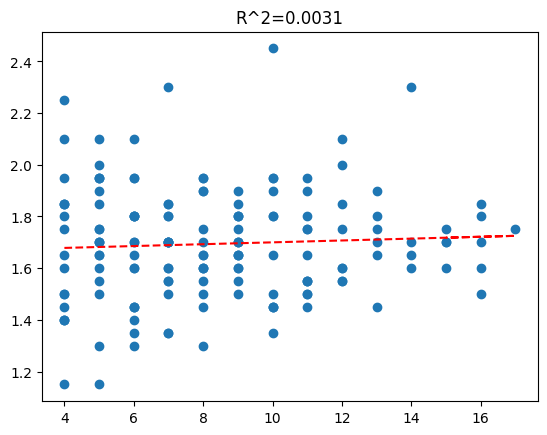

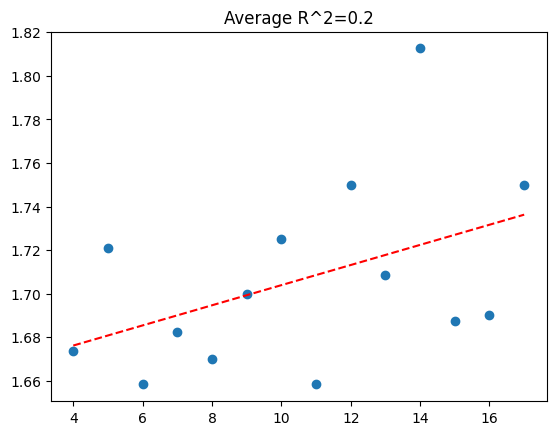

In [19]:
# Steering Law Evaluation

a,b,r2,sl_data = calculate_r2(rollouts, average_r2=False)
plt.scatter(sl_data["ID"], sl_data["MT_ref"])
plt.plot(sl_data["ID"], sl_data["MT_pred"], "--", color="red")
plt.title(f"R^2={r2:.2g}")
## Average R^2:
a,b,r2,sl_data = calculate_r2(rollouts, average_r2=True)
plt.figure()
plt.scatter(sl_data["ID_means"], sl_data["MT_means_ref"])
plt.plot(sl_data["ID_means"], sl_data["MT_pred"], "--", color="red")
plt.title(f"Average R^2={r2:.2g}")

In [10]:
rollouts_combined[-1].data._impl.efc_J[:, :14] #.qfrc_constraint #__dir__()

Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.  

In [8]:
rollouts_combined[-1].data._impl.efc_J[:, :14] #.qfrc_constraint #__dir__()

Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.  

In [41]:
rollouts_combined[-1].data._impl.efc_J[:, :14] #.qfrc_constraint #__dir__()

Array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       , -0.       , -0.       , -0.       , -0.       ,
         0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       , -0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       , -0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ],
       [-0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.

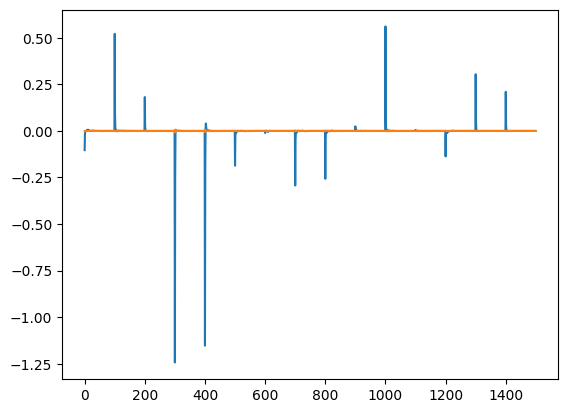

In [11]:
-1*rollouts_combined[0].data.qpos[env.mj_model.joint(("elv_angle")).id]+2/np.pi*rollouts_combined[0].data.qpos[env.mj_model.joint(("shoulder_elv")).id]*rollouts_combined[0].data.qpos[env.mj_model.joint(("elv_angle")).id], \
 -((jp.pi - 2 * rollouts_combined[0].data.qpos[env.mj_model.joint(("shoulder_elv")).id]) / jp.pi)*rollouts_combined[0].data.qpos[env.mj_model.joint(("elv_angle")).id], \
rollouts_combined[0].data.qpos[env.mj_model.joint(("shoulder1_r2")).id]

# [-((jp.pi - 2 * 0 * r.data.qpos[env.mj_model.joint(("shoulder_elv")).id]) / jp.pi)*r.data.qpos[env.mj_model.joint(("elv_angle")).id] - r.data.qpos[env.mj_model.joint(("shoulder1_r2")).id] for r in rollouts_combined]
_test = [-((jp.pi - 2 * r.data.qpos[env.mj_model.joint(("shoulder_elv")).id]) / jp.pi)*r.data.qpos[env.mj_model.joint(("elv_angle")).id] - r.data.qpos[env.mj_model.joint(("shoulder1_r2")).id] for r in rollouts_combined]
_test2 = [r.data.qpos[0] for r in rollouts_combined]

import matplotlib.pyplot as plt
plt.plot(_test)
plt.plot(_test2)

# [(r.data.qpos[env.mj_model.joint(("shoulder1_r2")).id] +r.data.qpos[env.mj_model.joint(("elv_angle")).id]) for r in rollouts_combined]

In [ ]:
render_traj(rollouts, eval_env=env) #, camera=None)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:03<00:00, 422.07it/s]


In [14]:
[r.metrics for r in rollouts[0]]

[{'bonus_reward': Array(0., dtype=float32, weak_type=True),
  'completed_phase_0': Array(0., dtype=float32, weak_type=True),
  'completed_phase_1': Array(0., dtype=float32, weak_type=True),
  'dist': Array(0.91545415, dtype=float32),
  'distance_phase_0': Array(0.91545415, dtype=float32),
  'distance_phase_1': Array(0., dtype=float32),
  'distance_reward': Array(-0.91545415, dtype=float32),
  'jac_effort_reward': Array(-0., dtype=float32),
  'not_touching': Array(0., dtype=float32, weak_type=True),
  'out_of_bounds': Array(0., dtype=float32, weak_type=True),
  'phase_1_x_dist': Array(0.23169523, dtype=float32),
  'softcons_for_bounds': Array(1., dtype=float32),
  'touch_reward': Array(-0.5, dtype=float32),
  'tunnel_reward': Array(-0., dtype=float32, weak_type=True)},
 {'bonus_reward': Array(0., dtype=float32, weak_type=True),
  'completed_phase_0': Array(0., dtype=float32, weak_type=True),
  'completed_phase_1': Array(0., dtype=float32, weak_type=True),
  'dist': Array(0.72494155, dty

In [ ]:
[(r.obs["proprioception"][15:18], r.obs["proprioception"][47:50]) for r in rollouts_combined]

[(Array([ 0.03493699, -0.198526  ,  0.28504306], dtype=float32),
  Array([ 0.5       , -0.05966789,  0.95312196], dtype=float32)),
 (Array([ 0.04321903, -0.20694444,  0.2865013 ], dtype=float32),
  Array([ 0.5       , -0.05966789,  0.95312196], dtype=float32)),
 (Array([ 0.09450396, -0.22791187,  0.298051  ], dtype=float32),
  Array([ 0.5       , -0.05966789,  0.95312196], dtype=float32)),
 (Array([ 0.19809219, -0.24103165,  0.34398323], dtype=float32),
  Array([ 0.5       , -0.05966789,  0.95312196], dtype=float32)),
 (Array([ 0.33882892, -0.21474227,  0.48161364], dtype=float32),
  Array([ 0.5       , -0.05966789,  0.95312196], dtype=float32)),
 (Array([ 0.40011418, -0.13481002,  0.71028936], dtype=float32),
  Array([ 0.5       , -0.05966789,  0.95312196], dtype=float32)),
 (Array([ 0.3625064 , -0.07929441,  0.8808954 ], dtype=float32),
  Array([ 0.5       , -0.05966789,  0.95312196], dtype=float32)),
 (Array([ 0.367423  , -0.06623739,  0.921308  ], dtype=float32),
  Array([ 0.5     

In [11]:
env.mj_model.site_pos[env.end_line_id, :], env.mj_model.site_pos[env.screen_id, :], env.mj_model.body("screen").pos

(array([-0.00999999, -0.13367838,  0.10312194]),
 array([0., 0., 0.]),
 array([ 0.5 , -0.35,  0.85]))

In [8]:
rollout_stored[0].info["end_line"], rollout_stored[0].info["screen_pos"] , rollout_stored[0].data.site_xpos[env.end_line_id], rollout_stored[0].data.site_xpos[env.screen_id]

(Array([ 0.6       , -0.48367837,  0.95312196], dtype=float32),
 Array([ 0.6 , -0.35,  0.85], dtype=float32),
 Array([ 0.59000003, -0.7       ,  0.875     ], dtype=float32),
 Array([ 0.6 , -0.35,  0.85], dtype=float32))

In [9]:
rollout_stored[0].info["end_line"], rollout_stored[0].info["screen_pos"] , rollout_stored[0].data.site_xpos[env.end_line_id], rollout_stored[0].data.site_xpos[env.screen_id]

(Array([ 0.6       , -0.48367837,  0.95312196], dtype=float32),
 Array([ 0.6 , -0.35,  0.85], dtype=float32),
 Array([ 0.59000003, -0.7       ,  0.875     ], dtype=float32),
 Array([ 0.6 , -0.35,  0.85], dtype=float32))

In [13]:
env.mj_model.site_pos[env.end_line_id, :], env.mj_model.site_pos[env.screen_id, :], env.mj_model.body("screen").pos

(array([ 0.        , -0.13367838,  0.10312194]),
 array([0., 0., 0.]),
 array([ 0.6 , -0.35,  0.85]))

In [26]:
init_state.info["end_line"] - init_state.info["screen_pos"] , init_state.data.site_xpos[env.end_line_id] - init_state.data.site_xpos[env.screen_id]

(Array([ 0.        , -0.13367838,  0.10312194], dtype=float32),
 Array([-0.00999999, -0.35      ,  0.02499998], dtype=float32))

In [ ]:
rorollouts_combinedllout[0].info["end_line"] - rollouts_combined[0].info["screen_pos"] , rollouts_combined[0].data.site_xpos[env.end_line_id] - rollouts_combined[0].data.site_xpos[env.screen_id]

(Array([ 0.        , -0.13367838,  0.10312194], dtype=float32),
 Array([-0.00999999, -0.35      ,  0.02499998], dtype=float32))

In [8]:
env.mj_model.site_pos[env.end_line_id], init_state.data.site_xpos[env.end_line_id], env.mj_model.site_pos[env.screen_id], init_state.data.site_xpos[env.screen_id]

(array([-1.01327896e-06, -5.03678381e-01,  1.03121936e-01]),
 Array([ 0.59000003, -0.7       ,  0.875     ], dtype=float32),
 array([0., 0., 0.]),
 Array([ 0.6 , -0.35,  0.85], dtype=float32))

In [11]:
env.mj_model.site_pos[env.end_line_id], init_state.data.site_xpos[env.end_line_id], env.mj_model.site_pos[env.screen_id], init_state.data.site_xpos[env.screen_id]

(array([ 0.        , -0.13367838,  0.10312194]),
 Array([ 0.59000003, -0.7       ,  0.875     ], dtype=float32),
 array([0., 0., 0.]),
 Array([ 0.6 , -0.35,  0.85], dtype=float32))

In [ ]:
render_traj(rollouts, eval_env=env)

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:00<00:00, 688.32it/s]


In [ ]:
[(r.data.site_xpos[env.fingertip_id], r.info["end_line"]) for r in rollouts_combined]
([(r.reward, r.metrics["phase_1_x_dist"], r.metrics["con_1_crossed_line_y"]) for r in rollouts_combined[:80]])#, [r.done for r in rollouts_combined[:80]]
# rollouts_combined[0].metrics.keys()

[(Array(0., dtype=float32),
  Array(0., dtype=float32, weak_type=True),
  Array(False, dtype=bool)),
 (Array(-4.745425, dtype=float32),
  Array(0.45678097, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-4.712586, dtype=float32),
  Array(0.40549603, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-4.627638, dtype=float32),
  Array(0.3019078, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-4.4458766, dtype=float32),
  Array(0.16117108, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-4.1971245, dtype=float32),
  Array(0.09988582, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-4.0805554, dtype=float32),
  Array(0.13749361, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-4.060509, dtype=float32),
  Array(0.132577, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-4.011795, dtype=float32),
  Array(0.07837212, dtype=float32),
  Array(False, dtype=bool)),
 (Array(-3.9762263, dtype=float32),
  Array(0.02909961, dtype=float32),
  Array(False, dtype=bool))

In [ ]:
[(r.metrics['distance_phase_0'], r.metrics['distance_phase_1'], r.metrics['dist']) for r in rollouts_combined]
[(r.obs['proprioception'][15:18], r.obs['proprioception'][50:53], r.metrics['con_1_touching_screen']) for r in rollouts_combined]


[(Array([ 0.03493699, -0.198526  ,  0.28504306], dtype=float32),
  Array([ 0.5       , -0.48367837,  0.95312196], dtype=float32),
  Array(False, dtype=bool)),
 (Array([ 0.04321903, -0.20694444,  0.2865013 ], dtype=float32),
  Array([ 0.5       , -0.48367837,  0.95312196], dtype=float32),
  Array(False, dtype=bool)),
 (Array([ 0.09450396, -0.22791187,  0.298051  ], dtype=float32),
  Array([ 0.5       , -0.48367837,  0.95312196], dtype=float32),
  Array(False, dtype=bool)),
 (Array([ 0.19809219, -0.24103165,  0.34398323], dtype=float32),
  Array([ 0.5       , -0.48367837,  0.95312196], dtype=float32),
  Array(False, dtype=bool)),
 (Array([ 0.33882892, -0.21474227,  0.48161364], dtype=float32),
  Array([ 0.5       , -0.48367837,  0.95312196], dtype=float32),
  Array(False, dtype=bool)),
 (Array([ 0.40011418, -0.13481002,  0.71028936], dtype=float32),
  Array([ 0.5       , -0.48367837,  0.95312196], dtype=float32),
  Array(False, dtype=bool)),
 (Array([ 0.3625064 , -0.07929441,  0.8808954 

In [49]:
touch_detected = any([{eval_env.mj_model.geom(con[0]).name, eval_env.mj_model.geom(con[1]).name} == {"fingertip_contact", "screen"} for con in state.data._impl.contact.geom])
touches = [{eval_env.mj_model.geom(con[0]).name, eval_env.mj_model.geom(con[1]).name} for con in state.data._impl.contact.geom]

touch_detected, touches

(True, [{'fingertip_contact', 'screen'}])

In [51]:
state.data._impl.contact.dist

Array([1.], dtype=float32)

In [41]:
eval_env.mj_model.geom

<bound method PyCapsule.geom of <mujoco._structs.MjModel object at 0x7749d83c61b0>>

In [26]:
# eval_key, reset_keys = jax.random.split(eval_key)
# state = jit_reset(reset_keys)
# eval_key, key = jax.random.split(eval_key)
# ctrl, _ = jit_inference_fn(state.obs, key)  #VARIANT 1
state = jit_step(state, ctrl)
state.metrics["dist_combined"]
(np.exp(-state.metrics["dist_combined"]*10.) - 1.)/10., (np.exp(-1.5*10.) - 1.)/10.

(np.float32(-0.09992059), np.float64(-0.09999996940976795))

In [33]:
np.exp(-0.7*2), (np.exp(-1.5*2))

(np.float64(0.2465969639416065), np.float64(0.049787068367863944))

In [17]:
np.where([r.info["phase_0_done"] for r in rollout])[0][0]*env.unwrapped._ctrl_dt
[(r.info["phase_0_done"], r.reward) for r in rollout]

[(Array(False, dtype=bool), Array(0., dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09999998, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09999997, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09999994, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09999982, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09999924, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09999751, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09999336, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09998853, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09998377, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.0999779, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09997098, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.0999607, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.09995576, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.0999537, dtype=float32)),
 (Array(False, dtype=bool), Array(-0.0999264, dtype=

In [22]:
[i.info["target_pos"] for i in rollout], [_i.obs["proprioception"][15:18] for _i in rollout]

([Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32),
  Array([ 0.26876748, -0.24839334,  0.79923654], dtype=float32)],
 [Array([ 0.03493699, -0.198526  ,  0.28504306], dtype=float32),
  Array([ 0.05467008, -0.20556903,  0.2879694 ], dtype=float32),
  Array([ 0.12839839, -0

In [11]:
np.sum(rewards)

np.float32(7.423525)

Test equality constraint

In [12]:
rng_init = jax.random.PRNGKey(0)
init_state = env.reset(rng_init)

In [21]:
init_state.data.qpos

from mujoco_playground._src import mjx_env
reset_qpos, reset_qvel, reset_act = env._reset_zero(rng_init)
data = mjx_env.init(env.mjx_model, qpos=reset_qpos, qvel=reset_qvel, act=reset_act)
reset_qpos, reset_qvel, reset_act = env._reset_range_uniform(rng_init, data)
jnt_range = env._mj_model.jnt_range[env._independent_joints]
nqi = len(env._independent_qpos)
rng, rng1, rng2, rng3 = jax.random.split(rng_init, 4)
qpos = jax.random.uniform(
            rng1, shape=(nqi,), minval=jnt_range[:, 0], maxval=jnt_range[:, 1]
        )
qvel = jax.random.uniform(
    rng2,
    shape=(nqi,),
    minval=jp.ones((nqi,)) * -0.05,
    maxval=jp.ones((nqi,)) * 0.05,
)
reset_qpos = jp.zeros((env._mj_model.nq,))
reset_qvel = jp.zeros((env._mj_model.nv,))
reset_act = jax.random.uniform(
    rng3,
    shape=env._na,
    minval=jp.zeros((env._na,)),
    maxval=jp.ones((env._na,)),
)

# Set qpos and qvel
reset_qpos = reset_qpos.at[env._independent_qpos].set(qpos)
# reset_qpos[self._dependent_qpos] = 0
reset_qvel = reset_qvel.at[env._independent_dofs].set(qvel)

_joint_constraints = env.mjx_model.eq_type == 2
_active_eq_constraints = data.eq_active == 1

eq_dep, eq_indep, poly_coefs = jp.array(env.mjx_model.eq_obj1id), \
    jp.array(env.mjx_model.eq_obj2id), \
    jp.array(env.mjx_model.eq_data[:, 2::-1])
eq_indep2 = jp.array(env.mjx_model.eq_data[:, 4], dtype=jp.int32)
linear_coef_indep2 = jp.array(env.mjx_model.eq_data[:, 3] * (eq_indep2 > 0))

reset_qpos_new = jp.where(jp.array([jp.any((eq_dep == i) & _joint_constraints & _active_eq_constraints) for i in range(env.mjx_model.njnt)]), 
                            jp.array([jp.polyval(poly_coefs[jp.argwhere(eq_dep == i, size=1).flatten(), :].flatten(), reset_qpos[eq_indep[jp.argwhere(eq_dep == i, size=1).flatten()]]) + jp.dot(jp.dot(linear_coef_indep2[jp.argwhere(eq_dep == i, size=1).flatten()].flatten(), reset_qpos[eq_indep2[jp.argwhere(eq_dep == i, size=1).flatten()]]), reset_qpos[eq_indep[jp.argwhere(eq_dep == i, size=1).flatten()]]) for i in range(env.mjx_model.njnt)]).flatten(),
                            reset_qpos)

-1*init_state.data.qpos[env.mj_model.joint(("elv_angle")).id]+2/np.pi*init_state.data.qpos[env.mj_model.joint(("shoulder_elv")).id]*init_state.data.qpos[env.mj_model.joint(("elv_angle")).id], \
 -((jp.pi - 2 * init_state.data.qpos[env.mj_model.joint(("shoulder_elv")).id]) / jp.pi)*init_state.data.qpos[env.mj_model.joint(("elv_angle")).id], \
init_state.data.qpos[env.mj_model.joint(("shoulder1_r2")).id]

# reset_qpos, data.qpos, jnt_range, reset_qpos_new, data.qpos, init_state.data.qpos

(Array(0.33676845, dtype=float32),
 Array(0.3367684, dtype=float32),
 Array(1.94643, dtype=float32))

In [52]:
from mujoco.mjx._src.types import EqType
eq_id = np.nonzero(m.eq_type == EqType.JOINT)[0]
eq_id

args = (m.eq_obj1id, m.eq_obj2id, m.eq_data, m.eq_solref, m.eq_solimp)
args += (init_state.data.eq_active,)
args = jax.tree_util.tree_map(lambda x: x[eq_id], args)
args[1]
# data.shape
# pos2
obj1id
pos1 - ref1 - jp.dot(data[:, :3], dif_power)# - data[3] * dif3 * dif

TypeError: dot_general requires contracting dimensions to have the same shape, got (3,) and (12,).

In [50]:
data.shape, dif_power.shape

((12, 11), (12, 3))

In [71]:
def _efc_equality_joint(m, d):
  """Calculates constraint rows for joint equality constraints."""

  eq_id = np.nonzero(m.eq_type == EqType.JOINT)[0]

#   if (m.opt.disableflags & DisableBit.EQUALITY) or eq_id.size == 0:
#     return None

  @jax.vmap
  def rows(
      obj2id, data, solref, solimp, active, dofadr1, dofadr2, qposadr1, qposadr2
  ):
    pos1, pos2 = d.qpos[qposadr1], d.qpos[qposadr2]
    ref1, ref2 = m.qpos0[qposadr1], m.qpos0[qposadr2]
    dif = (pos2 - ref2) * (obj2id > -1)
    dif_power = jp.power(dif, jp.arange(0, 3))
    eq_obj3id = data[4].astype(jp.int32)
    dofadr3, qposadr3 = jp.asarray(m.jnt_dofadr)[eq_obj3id], jp.asarray(m.jnt_qposadr)[eq_obj3id]
    pos3, ref3 = d.qpos[qposadr3], m.qpos0[qposadr3]
    dif3 = (pos3 - ref3) * (eq_obj3id > 0)
    pos = pos1 - ref1 - jp.dot(data[:3], dif_power) - data[3] * dif3 * dif
    deriv = (jp.dot(data[1:3], dif_power[:2] * jp.arange(1, 3)) + data[3] * dif3) * (obj2id > -1)
    deriv3 = (data[3] * dif) * (eq_obj3id > 0)
    return pos1 - ref1, pos, deriv, deriv3

    j = jp.zeros((m.nv)).at[dofadr2].set(-deriv).at[dofadr1].set(1.0).at[dofadr3].set(-deriv3)
    invweight = m.dof_invweight0[dofadr1]
    invweight += m.dof_invweight0[dofadr2] * (obj2id > -1)
    invweight += m.dof_invweight0[dofadr3] * (eq_obj3id > 0)
    zero = jp.zeros_like(pos)

    efc = _row(j, pos, pos, invweight, solref, solimp, zero, zero)
    return jax.tree_util.tree_map(lambda x: x * active, efc)
  
  @jax.vmap
  def rows_OLD(
      obj2id, data, solref, solimp, active, dofadr1, dofadr2, qposadr1, qposadr2
  ):
    pos1, pos2 = d.qpos[qposadr1], d.qpos[qposadr2]
    ref1, ref2 = m.qpos0[qposadr1], m.qpos0[qposadr2]
    dif = (pos2 - ref2) * (obj2id > -1)
    dif_power = jp.power(dif, jp.arange(0, 3))
    pos = pos1 - ref1 - jp.dot(data[:3], dif_power)
    deriv = jp.dot(data[1:3], dif_power[:2] * jp.arange(1, 3)) * (obj2id > -1)
    return pos1 - ref1, pos, deriv, None

    j = jp.zeros((m.nv)).at[dofadr2].set(-deriv).at[dofadr1].set(1.0)
    invweight = m.dof_invweight0[dofadr1]
    invweight += m.dof_invweight0[dofadr2] * (obj2id > -1)
    zero = jp.zeros_like(pos)

    efc = _row(j, pos, pos, invweight, solref, solimp, zero, zero)
    return jax.tree_util.tree_map(lambda x: x * active, efc)

  args = (m.eq_obj1id, m.eq_obj2id, m.eq_data, m.eq_solref, m.eq_solimp)
  args += (d.eq_active,)
  args = jax.tree_util.tree_map(lambda x: x[eq_id], args)
  dofadr1, dofadr2 = m.jnt_dofadr[args[0]], m.jnt_dofadr[args[1]]
  qposadr1, qposadr2 = m.jnt_qposadr[args[0]], m.jnt_qposadr[args[1]]
  args = args[1:] + (dofadr1, dofadr2, qposadr1, qposadr2)

  return rows(*args)
_init_state_qpos = init_state.data.qpos.at[13].set(0.33676845)   #0.33676845  #1.220145
init_state_data = init_state.data.replace(qpos=_init_state_qpos)
init_state_data.qpos, _efc_equality_joint(env.mjx_model, init_state_data)

(Array([ 0.        , -0.27537513,  0.11663568, -0.11663568,  0.27537513,
        -0.05575777,  0.45061424,  0.20254782, -0.20254782, -0.45061424,
         0.05575777, -1.2220145 ,  1.137909  ,  0.33676845, -0.37709522,
         0.35945842, -0.09703195], dtype=float32),
 (Array([-0.27537513,  0.11663568,  0.27537513, -0.11663568,  0.20254782,
         -0.05575777,  0.45061424, -0.20254782,  0.05575777, -0.45061424,
          0.33676845,  0.        ], dtype=float32),
  Array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 5.9604645e-08, 0.0000000e+00],      dtype=float32),
  Array([-0.242001  ,  0.1025    ,  0.242001  , -0.1025    ,  0.178     ,
         -0.0490002 ,  0.396002  , -0.178     ,  0.0490002 , -0.396002  ,
         -0.27558458,  0.        ], dtype=float32),
  Array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,